# Recommender systems - collaborative filtering

## Notation

Number of users: $n_u$

Number of items: $n_m$ (e.g. movies in the database)

Number of features: $n$

There is / there isn't a rating: $r(i, j) = 1$ if user $j$ has rated item $i$

Ratings: $y^{(i, j)}$: rating of item $i$ given by user $j$

## Using per-item features

Items are assigned $n$ features.

The ratings (preditions) are defined as a linear function of the features, defined user by user.

Predicted rating given to item $i$ by user $j$: 

$$y^{(i, j)} = w^{(j)} \cdot x^{(i)} + b^{(j)}$$

### Cost function

$m^{(j)}$: number of items rated by user $j$

Cost function (with regularization) for one user $j$:

$$\min_{w^{(j)}b^{(j)}} J(w^{(j)}, b^{(j)}) = \frac{1}{2}\sum_{i:r(i,j)=1}(w^{(j)} \cdot x^{(i)}+b^{(j)}-y^{(i, j)})^2 + \frac{\lambda}{2}\sum^n_{k=1}(w_k^{(j)})^2$$

Cost function for all users at once:

$$\min_{\substack{w^{(1)}, \dots, w^{(n_u)}\\b^{(1)}, \dots, b^{(n_u)}}} J(\substack{w^{(1)}\dots w^{(n_u)}\\b^{(1)}\dots b^{(n_u)}}) = \frac{1}{2}\sum_{j=1}^{n_u}\sum_{i:r(i,j)=1}(w^{(j)} \cdot x^{(i)}+b^{(j)}-y^{(i, j)})^2 + \frac{\lambda}{2}\sum_{j=1}^{n_u}\sum^n_{k=1}(w_k^{(j)})^2$$

## Collaborative filtering algorithm (i.e., without per-item features)

The algorithm has to find the parameters of the linear regressions and <u>the features</u>. Therefore,

### Non-binary labels

#### Cost function

$$\min_{\substack{w^{(1)}\dots w^{(n_u)}\\b^{(1)}\dots b^{(n_u)}\\x^{(1)}\dots x^{(n_m)}}} J(w, b, x) = \frac{1}{2}\sum_{(i,j):r(i,j)=1}(w^{(j)} \cdot x^{(i)}+b^{(j)}-y^{(i, j)})^2 + \frac{\lambda}{2}\sum_{j=1}^{n_u}\sum^n_{k=1}(w_k^{(j)})^2 + \frac{\lambda}{2}\sum_{i=1}^{n_m}\sum^n_{k=1}(x_k^{(i)})^2$$

### Binary labels (favs, likes, and clicks)

Instead of the user giving a rating (e.g., from 0 to 5) it gives or we assign a binary label.

In this case, instead of predicting $y^{(i, j)} = w^{(j)} \cdot x^{(i)} + b^{(j)}$ we are predicting the probability of $y^{(i, j)}$ being 1.

$$p(y^{(i,j)} = 1) = g(w^{(j)} \cdot x^{(i)} + b^{(j)}) \\ \text{ where } g(z) = \frac{1}{1 + e^{-z}}$$

#### Cost function

Loss for a single sample:

$$f_{(w, b, x)} = g(w^{(j)} \cdot x^{(i)} + b^{(j)})$$ 

$$Loss(f_{(w, b, x)}(x), y^{(i,j)}) = -y^{(i,j)} \log(f_{(w, b, x)}(x)) - (1 - y^{(i,j)}) \log(1 - f_{(w, b, x)}(x))$$

Cost function:

$$J(w,b,x) = \sum_{(i,j):r(i,j)=1} Loss(f_{(w, b, x)}(x), y^{(i,j)})$$

## Implementation details

### Mean normalization

The idea is to normalize the ratings with the means (across each item) and make the predictions be:

$$w^{(j)} \cdot x^{(i)} + b^{(j)} + \mu_i$$

Implicitly making the prediction for a non rated item equal to the mean.

### Implementation in TensorFlow

Simplified example, $$J = (wx -1)^2$$

Algorithm:

<pre>
Repeat until convergence:
</pre>
&nbsp;&nbsp;&nbsp; $w = w - \alpha \frac{\partial}{\partial w}J(w,b)$

With TensorFlow:

``` python
w = tf.Variable(3.0)
x = 1.0
y = 1.0 # Target value
alpha = 0.1

iterations = 30
for iter in range(iterations):
    # Use TensorFLow's Gradient tape to record the steps
    # used to compute the cosr L to enable auto differentiation
    with tf.GradientTape() as tape:
        fwb = w*x
        costJ = (fwb - y)^2

    # Use the gradient tape to calculate the gradients
    # of the cost with respect to the parameter w
    [dJdw] = tape.gradient(costJ, [w])

    # Run one step gradient descent by updating
    # the value of w to reduce the cost
    w.assign_add(-alpha * dJdw)
```

### Finding related items

To find the item with $x^{(k)}$ more similar to $x^{(i)}$, once you have run the algorithm above, and you have determined the features $x^{(i)}$, you look for the item closer to $x^{(i)}$

$$\left\Vert x^{(k)} - x^{(i)}\right\Vert^2 = \sum_{l=1}^n (x^{(k)}_l - x^{(i)}_l)^2$$

### Limitations

* Cold start:
    * Rank new items that few users have rated yet
    * Make recomendations to users who have rated few items (although mean normalization helps)

* Does not factor in information (features) already know about the users or the items (e.g. preferences)


# Python, vectorized implementation

Terminology:

Number of users: $n_u$

Number of items: $n_m$ 

Number of features: $n$


Matrix representations:

* X is the matrix of features, $n_m$ x $n$ where row i represents the features of item i

$$X = \begin{bmatrix} ---(x^{(0)})^T--- \\ \vdots \\ ---(x^{(n_m - 1)})^T--- \end{bmatrix}$$

* W is the matrix of parameters, $n_u$ x $n$ where row j represents the parameters for user j

$$W = \begin{bmatrix} ---(w^{(0)})^T--- \\ \vdots \\ ---(w^{(n_u -1)})^T--- \end{bmatrix}$$

* b is the vector of biases, $n_u$

$$b = \begin{bmatrix} b^{(0)} \\ \vdots \\ b^{(n_u -1)} \end{bmatrix}$$

* Y is the matrix of ratings, $n_m$ x $n_u$

$$Y = \begin{bmatrix} y_{0, 0} \dots y_{0, n_{n_u-1}} \\ \vdots \\ y_{n_{m-1}, 0} \dots y_{n_{(m-1)}, n_{n_u-1}} \end{bmatrix}$$

* R is a flag matrix telling if user $j$ has rated item $i$, $n_m$ x $n_u$ 

$$R = \begin{bmatrix} r_{0, 0} \dots r_{0, n_{n_u-1}} \\ \vdots \\ r_{n_{m-1}, 0} \dots r_{n_{(m-1)}, n_{n_u-1}} \end{bmatrix}$$

Predictions:

$$ \hat{Y} = X * W^T + b^T$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

2023-02-24 19:19:02.600687: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def cofi_cost_function(X, W, b, Y, R, lambda_):
    """
    Cost function for collaborative filtering
    Args:
      X (ndarray (n_m, n)) : item features
      W (ndarray (n_u, n)) : user parameters
      b (ndarray (n_u, 1)  : user bias parameters
      Y (ndarray (n_m, n_u): user ratings
      R (ndarray (n_m, n_u): R(i, j) = 1 if the i-th item was rated by the j-th user
      lambda_ (float)      : regularization parameter
    Returns:
      J (float) : Cost
    """

    return 0.5*np.sum((((np.matmul(X, W.T) + b.T) - Y)*R) ** 2) + (lambda_/2)*(np.sum(W**2) + np.sum(X**2))

In [3]:
def cofi_cost_function_tf(X, W, b, Y, R, lambda_):
    """
    Cost function for collaborative filtering, implemented using TensorFlow
    Args:
      X (ndarray (n_m, n)) : item features
      W (ndarray (n_u, n)) : user parameters
      b (ndarray (n_u, 1)  : user bias parameters
      Y (ndarray (n_m, n_u): user ratings
      R (ndarray (n_m, n_u): R(i, j) = 1 if the i-th item was rated by the j-th user
      lambda_ (float)      : regularization parameter
    Returns:
      J (float) : Cost
    """
    j = (tf.linalg.matmul(X, tf.transpose(W)) + tf.transpose(b) - Y)*R
    J = 0.5 * tf.reduce_sum(j**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
    return J

In [4]:
def recommender(Y_, R_, n, lambda_=1.0, iterations=200):
    '''
    Implements a collaborative recommender system with TensorFlow
    Args:
      Y_ (ndarray (n_m, n_u)  : user ratings
      R_ (ndarray (n_m, n_u)  : R(i, j) = 1 if the i-th item was rated by the j-th user
      n (int)                 : number of item features to extract
      lambda_ (float)         : regularization parameter
      iterations (float)      : number of iterations in the gradient descent optimization
    Returns:
      X (ndarray (n_m, n))    : item features
      W (ndarray (n_u, n))    : user parameters
      b (ndarray (n_u, 1)     : user bias parameters
    '''

    # Some useful values

    n_m, n_u = Y_.shape

    # Convert to tensorflow constant

    R = tf.constant(R_, dtype=tf.float64, name='R')
    Y = tf.constant(Y_, dtype=tf.float64, name='Y')

    # Initialize parameters

    tf.random.set_seed(1)

    W = tf.Variable(tf.random.normal((n_u, n), dtype=tf.float64), name='W')
    X = tf.Variable(tf.random.normal((n_m, n), dtype=tf.float64), name='X')
    b = tf.Variable(tf.random.normal((n_u, 1), dtype=tf.float64), name='b')

    # Instantiate an optimizer

    optimizer = keras.optimizers.Adam(learning_rate=0.1)

    # Optimization

    for iter in range(iterations):
        with tf.GradientTape() as tape:
            # Compute cost
            cost_value = cofi_cost_function_tf(X, W, b, Y, R, lambda_)        

        grads = tape.gradient(cost_value, [X, W, b])

        optimizer.apply_gradients(zip(grads, [X, W, b]))

        if iter % 20 == 0:
            print(f"Training loss at iteration {iter}: {cost_value:,.1f}")

    return X.numpy(), W.numpy(), b.numpy()

In [5]:

# Read data: copy of the https://grouplens.org/datasets/movielens/latest/ dataset

movies = pd.read_csv(
    "data/MovieLens/movies.csv",
    index_col='movieId')

ratings = pd.read_csv(
    'data/MovieLens/ratings.csv', 
    usecols=['userId', 'movieId', 'rating']
).pivot_table(
    values=['rating'], 
    columns= ['userId'], 
    index=['movieId']
).droplevel(
    0, 
    axis=1
)

# Drop movies with few ratings (less than 20). 

ratings = ratings.loc[Y_df.count(axis=1) >= 20].dropna(axis=1, how='all')

Y_raw = ratings.to_numpy()

n_m = Y_raw.shape[0]    # Number of items (movies)
n_u = Y_raw.shape[1]    # Number of users
n = 100                 # Number of features we will use

print(f"Num items (movies), n_m: {n_m}")
print(f"Num users, n_u: {n_u}")
print(f"Num features, n: {n}")

#_, _, _ = plt.hist(Y_raw[1,:])


Num items (movies), n_m: 1297
Num users, n_u: 610
Num features, n: 100


In [6]:
# Normalize ratings, nan converted to 0 after calculating the mean
Y_mean = np.nanmean(Y_raw, axis=1, keepdims=True)
Y = np.nan_to_num(Y_raw - Y_mean)

# Calculate R
R = (~np.isnan(Y_raw)).astype(int)

In [7]:
# Run recommender

X, W, b = recommender(Y, R, n, lambda_=1, iterations = 200)

2023-02-24 19:19:28.398692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 19:19:28.774549: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 


Training loss at iteration 0: 3,554,636.9
Training loss at iteration 20: 102,161.4
Training loss at iteration 40: 46,436.3
Training loss at iteration 60: 28,831.6
Training loss at iteration 80: 19,507.8
Training loss at iteration 100: 13,930.0
Training loss at iteration 120: 10,416.6
Training loss at iteration 140: 8,153.9
Training loss at iteration 160: 6,672.9
Training loss at iteration 180: 5,688.0


In [8]:
# Predict

p = np.matmul(X, W.T) +b.T + Y_mean


In [9]:
# Movies not rated are assigned the mean

print(f"Prediction: {p[0,1]}, actual: {Y_raw[0,1]}, mean for movie 0: {Y_mean[0]}")
print(f"Prediction: {p[0,4]}, actual: {Y_raw[0,4]}, mean for movie 0: {Y_mean[0]}")

Prediction: 3.981132887522727, actual: nan, mean for movie 0: [3.92093023]
Prediction: 3.9921912562038875, actual: 4.0, mean for movie 0: [3.92093023]


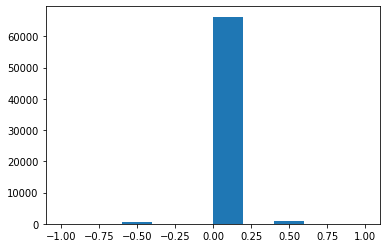

In [10]:
# This calculation excludes non rated items. Error is calculated in terms of half points
error = np.round(np.divide(p - Y_raw, 0.5))*0.5

_, _, _ = plt.hist(error.reshape(-1))

# Mean error by user
#_, _, _ = plt.hist(np.nanmean(error, axis=0))


In [11]:
# Precision
print(f"Precision (% of predictions within +/- of original rating): {np.sum(np.abs(error) <= 0.5)/np.nansum(~np.isnan(Y_raw)):0.4}")

Precision (% of predictions within +/- of original rating): 1.0


In [12]:
# Movies closer to ...

movieId = movies.index[movies['title'] == 'Aladdin (1992)'].values[0]
#movieId = movies.index[movies['title'] == 'Four Weddings and a Funeral (1994)'].values[0]
#movieId = movies.index[movies['title'] == 'Star Trek: The Motion Picture (1979)'].values[0]
row_num = ratings.index.get_loc(movieId)

distances = np.sum((X - X[row_num])**2, axis=1)

ratings['dist'] = distances.tolist()

# Add count of ratings to each movie. 
ratings['num_ratings'] = np.nansum(np.divide(Y_raw, Y_raw), axis=1)

# Closer movies. Selection is done out of movies with enough number of ratings. Low rated movies would otherwise 
# will have a high chance to show in the list.
movies.loc[ratings.loc[ratings['num_ratings'] >= 20].sort_values('dist', ascending=True).head(10).index]

,title,genres
movieId,,
588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
3698,"Running Man, The (1987)",Action|Sci-Fi
18,Four Rooms (1995),Comedy
1688,Anastasia (1997),Adventure|Animation|Children|Drama|Musical
107,Muppet Treasure Island (1996),Adventure|Children|Comedy|Musical
1285,Heathers (1989),Comedy
8622,Fahrenheit 9/11 (2004),Documentary
5283,National Lampoon's Van Wilder (2002),Comedy
45720,"Devil Wears Prada, The (2006)",Comedy|Drama


In [13]:
# Unit tests

import unittest 

class TestNotebook(unittest.TestCase):

    def test_cofi_cost_function_no_reg(self):
        X = np.array([[1, 2, 3, 4], [5, 6, 7, 8]])
        W = np.array([[0.5, 0.2, 0.1, 0.2], [0.1, 0.1, 0.2, 0.2], [0.3, 0.4, 0.1, 0.1]])
        b = np.array([[0.1], [0.2], [0.5]])
        Y = np.array([[2, 3, 5], [1, 2, 3]])
        R = np.array([[1, 1, 1], [1, 1, 1]])
        
        self.assertEqual(cofi_cost_function(X,W, b, Y, R, lambda_=0), 24.11)

    def test_cofi_cost_function_reg(self):
        X = np.array([[1, 2, 3, 4], [5, 6, 7, 8]])
        W = np.array([[0.5, 0.2, 0.1, 0.2], [0.1, 0.1, 0.2, 0.2], [0.3, 0.4, 0.1, 0.1]])
        b = np.array([[0.1], [0.2], [0.5]])
        Y = np.array([[2, 3, 5], [1, 2, 3]])
        R = np.array([[1, 1, 1], [1, 1, 1]])
        
        self.assertEqual(cofi_cost_function(X,W, b, Y, R, lambda_=0.1), 34.3455)

    def test_cofi_cost_function_tf_reg(self):
        X = tf.constant([[1., 2., 3., 4.], [5., 6., 7., 8.]])
        W = tf.constant([[0.5, 0.2, 0.1, 0.2], [0.1, 0.1, 0.2, 0.2], [0.3, 0.4, 0.1, 0.1]])
        b = tf.constant([[0.1], [0.2], [0.5]])
        Y = tf.constant([[2., 3., 5.], [1., 2., 3.]])
        R = tf.constant([[1., 1., 1.], [1., 1., 1.]])
        
        self.assertAlmostEqual(cofi_cost_function_tf(X,W, b, Y, R, lambda_=0.1).numpy(), 34.3455, 3)


unittest.main(argv=[''], verbosity=0, exit=False)

----------------------------------------------------------------------
Ran 3 tests in 1.813s

OK
